# Model Evaluation

This notebook will contain code that will be useful for determining the effectiveness of the produced models.

In [1]:
import os
import glob
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

import monai
from monai.transforms import \
    Compose, LoadNiftid, ScaleIntensityd, AddChanneld, ToTensord, RandSpatialCropd, CenterSpatialCropd, CropForegroundd, NormalizeIntensityd, RandCropByPosNegLabeld
from MONAIUNet import UNet

In [2]:
# Models:
# 'models/6-8-2020_Test/tb_logs/6-8-2020_Test/version_0/checkpoints/epoch=714.ckpt'
# 'models/6-9-2020_patched_64/tb_logs/6-9-2020_patched_64/version_0/checkpoints/epoch=994.ckpt'
# 'models/6-15-2020_celoss/tb_logs/6-15-2020_celoss/version_0/checkpoints/epoch=569.ckpt'
# 'models/6-16-2020_normalize/tb_logs/6-16-2020_normalize/version_0/checkpoints/epoch=664.ckpt'
test_checkpoint_path = 'models/6-16-2020_normalize/tb_logs/6-16-2020_normalize/version_0/checkpoints/epoch=664.ckpt'

In [3]:
criterion = monai.losses.DiceLoss(to_onehot_y=True, do_softmax=True)
model = UNet.load_from_checkpoint(
    test_checkpoint_path,
    dimensions=2,
    in_channels=1,
    out_channels=2,
    channels=(64, 128, 258, 512, 1024),
    strides=(2, 2, 2, 2),
    norm=monai.networks.layers.Norm.BATCH,
    criterion=criterion
)

In [4]:
def select_animals(images, masks, animals):
    """Returns the images and masks as a dictionary for specific animals."""
    filtered_images = []
    filtered_masks = []
    for animal in animals:
        filtered_images.extend(filter(lambda x: 'PSEA' + str(animal) in x, images))
        filtered_masks.extend(filter(lambda x: 'PSEA' + str(animal) in x, masks))
    return [{'image': image_file, 'mask': mask_file} for image_file, mask_file in zip(filtered_images, filtered_masks)]

### Data collection
data_dir = 'data/'
print('Available directories: ', os.listdir(data_dir))

# Get paths for images and masks, organize into dictionaries
images = sorted(glob.glob(data_dir + '**/*CTImg*', recursive=True))
masks = sorted(glob.glob(data_dir + '**/*Mask*', recursive=True))
data_dicts = [{'image': image_file, 'mask': mask_file} for image_file, mask_file in zip(images, masks)]

# Dataset selection
train_dicts = select_animals(images, masks, [12, 13, 14, 18, 20])
val_dicts = select_animals(images, masks, [25])
test_dicts = select_animals(images, masks, [27])
data_keys = ['image', 'mask']

Available directories:  ['PSEA12 Baseline', 'PSEA13 PostGel', 'PSEA27 PostGel', 'PSEA25 Baseline', 'PSEA12 PostGel', 'PSEA14 Baseline', 'PSEA14 PostGel', 'PSEA20 PostMI', 'PSEA18 PostMI', 'PSEA12 PostMI', 'PSEA18 Baseline', 'PSEA27 PostMI', 'PSEA13 Baseline', 'PSEA20 PostGel', 'PSEA25 PostMI', 'PSEA27 Baseline', 'PSEA13 PostMI', 'PSEA25 PostGel', 'PSEA18 PostGel']


In [5]:
data_keys = ['image', 'mask']
# test_transforms = Compose([
#     LoadNiftid(keys=data_keys),
#     AddChanneld(keys=data_keys),
#     ScaleIntensityd(keys=data_keys),
#     RandSpatialCropd(
#         keys=data_keys,
#         roi_size=(256, 256, 1),
#         random_size=False
#     ),
#     ToTensord(keys=data_keys)
# ])

test_transforms = Compose(
    [
        LoadNiftid(keys=data_keys),
        AddChanneld(keys=data_keys),
        NormalizeIntensityd(keys="image"),
        RandSpatialCropd(
            keys=data_keys,
            roi_size=(256, 256, 1),
            random_size=False
        ),
        ToTensord(keys=data_keys),
    ]
)

train_dataset = monai.data.Dataset(
    data=test_dicts,
    transform=test_transforms,
)

test_dataset = monai.data.Dataset(
    data=test_dicts,
    transform=test_transforms,
)

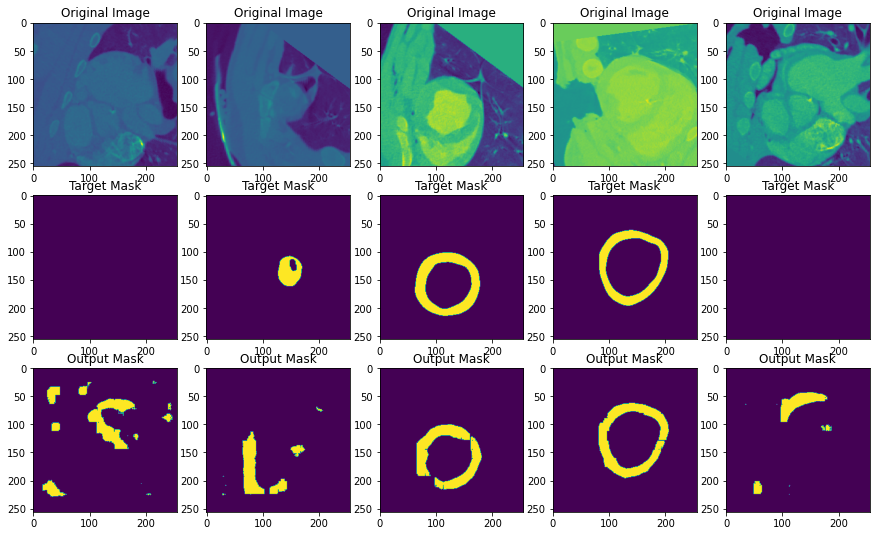

In [6]:
test_samples = random.sample(range(len(test_dataset)), 5)
fig, axs = plt.subplots(3, 5, figsize=(15, 9))

for i in range(5):
    sample = test_dataset[test_samples[i]]
    axs[0, i].imshow(sample['image'][0, :, :, 0])
    axs[0, i].set_title('Original Image')

    axs[1, i].imshow(sample['mask'][0, :, :, 0])
    axs[1, i].set_title('Target Mask')
    
    test_image = sample['image'].unsqueeze(0).squeeze(4)
    test_mask = model(test_image)
    test_mask = test_mask.argmax(1).squeeze(0).detach()
    axs[2, i].imshow(test_mask)
    axs[2, i].set_title('Output Mask')

plt.savefig('results/' + model.hparams.name + '.png')

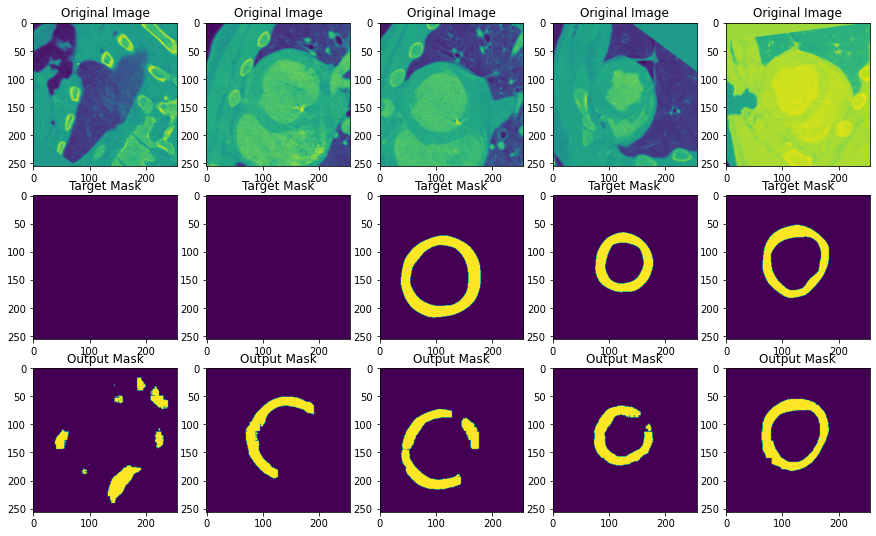

In [7]:
train_samples = random.sample(range(len(train_dataset)), 5)
fig, axs = plt.subplots(3, 5, figsize=(15, 9))

for i in range(5):
    sample = train_dataset[train_samples[i]]
    axs[0, i].imshow(sample['image'][0, :, :, 0])
    axs[0, i].set_title('Original Image')

    axs[1, i].imshow(sample['mask'][0, :, :, 0])
    axs[1, i].set_title('Target Mask')
    
    train_image = sample['image'].unsqueeze(0).squeeze(4)
    train_mask = model(train_image)
    train_mask = train_mask.argmax(1).squeeze(0).detach()
    axs[2, i].imshow(train_mask)
    axs[2, i].set_title('Output Mask')

